In [3]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torchtext
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

#connecting to gpu if cuda is available else use cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Importing necessary files and logging to wandb

In [4]:
!pip install wandb
import wandb
wandb.login(key="99ed1e6d8f514ee3823dec88049f21d48e678419")
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Function to read Dataset

In [5]:
import csv

def read_dataset(file_path):
    pairs = []
    with open(file_path, 'r', encoding='utf-8') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            romanized_str = row[0].strip()
            devanagari_str = row[1].strip()
            romanized_str='['+romanized_str+']'
            devanagari_str='['+devanagari_str+']'
            pairs.append((romanized_str, devanagari_str))
    return pairs

Loading the Dataset for Hindi language

In [7]:
#I have used the language hindi and done sweep on hindi language.
#for training on another language the train.py can be used

#loading the train dataset
file_path='/kaggle/input/aksharntrrr/aksharantar_sampled/hin/hin_train.csv'
pairs=read_dataset(file_path)

#loading the validation dataset
file_path='/kaggle/input/aksharntrrr/aksharantar_sampled/hin/hin_valid.csv'
valid_pairs=read_dataset(file_path)

#loading the test dataset
file_path='/kaggle/input/aksharntrrr/aksharantar_sampled/hin/hin_test.csv'
test_pairs=read_dataset(file_path)

In [6]:
SOS_token = '['
EOS_token = ']'


Creating the english (native-romanised) and hindi (latin-devanagiri) vocabulary and maps

In [8]:
native_words=[]
devgiri_words=[]

def prepare_vocabulary(pairs):
  
#here native_character_vocabulary stores all the english letters encountered in training dataset
#latin_character_vocabulary stores all the hindi letters encountered in training dataset
#native_enc_map stores the encoding (indices) for each letter in english vocabulary as (character,index)
#latin_enc_map stores the enocding (indices) for each letter in hindi vocabulary as (character,index)
#native_dec_map stores the decoding (char) for each index in english vocabulary as (index,character)
#latin_dec_map stores the decoding (char) for each index in hindi vocabulary as (index,character)
# '#' is used as padding character with corresponding index given as 0

  print("Creating vocabularies..................")
  native_character_vocabulary=set()
  latin_character_vocabulary=set()
  
  native_enc_map={}
  latin_enc_map={}
  for (x,y) in pairs:
    native_character_vocabulary=native_character_vocabulary.union(set(list(x)))
    latin_character_vocabulary=latin_character_vocabulary.union(set(list(y)))
    
  print("English vocabulary contains: ",len(native_character_vocabulary),"characters (including starting and end token)")
  print("Hindi vocabulary contains: ",len(latin_character_vocabulary),"characters (including start and end token)")

  #creating maps
  i=0
 
  native_enc_map['#']=0
  native_enc_map['[']=1
  native_enc_map[']']=2
  i=3
  for ch in native_character_vocabulary:
    if ch not in {'#','[',']'}:
      native_enc_map[ch]=i
      i+=1
  
  #for unknown character if encountered during validation or testing
  native_enc_map['?']=i
  
  #creating decoding map from encoding map
  native_dec_map = {v: k for k, v in native_enc_map.items()}

  #creating encoding map for hindi
  i=0
  latin_enc_map['#']=0
  latin_enc_map['[']=1
  latin_enc_map[']']=2
  i=3
  for ch in latin_character_vocabulary:
    if ch not in {'#','[',']'}:
      latin_enc_map[ch]=i
      i+=1

  #for unknown character if encountered during validation or testing
  latin_enc_map['?']=i


  native_character_vocabulary.add('#')
  native_character_vocabulary.add('[')
  
  latin_character_vocabulary.add('#')
  latin_character_vocabulary.add('[')
  native_character_vocabulary.add(']')
  latin_character_vocabulary.add(']')  
  
  #creating decoding maps for hindi language
  latin_dec_map = {v: k for k, v in latin_enc_map.items()}

  print("Created successfully!!")
  return native_character_vocabulary,latin_character_vocabulary,native_enc_map,latin_enc_map,native_dec_map,latin_dec_map,pairs


native_character_vocabulary,latin_character_vocabulary,native_enc_map,latin_enc_map,native_dec_map,latin_dec_map,pairs=prepare_vocabulary(pairs)






Creating vocabularies..................
English vocabulary contains:  28 characters (including starting and end token)
Hindi vocabulary contains:  66 characters (including start and end token)
Created successfully!!


Getting the maximum length for encoder and decoder

In [9]:
max_encoder_seq_length = max([len(x) for x,y in test_pairs])
max_decoder_seq_length = max([len(y) for x,y in pairs])


In [10]:
print(max_encoder_seq_length)
print(max_decoder_seq_length)

28
22


Function to create the input encodings and target encodings

In [12]:
from IPython.core.displayhook import Float
import numpy as np
from torch.nn.utils.rnn import pad_sequence

def prepare_encoding(input,native_char_map,latin_char_map,batch_size):

  #creates or tokenizes each input and target string present in the input i.e. converts it to numbers
  input_encoding=[torch.tensor([native_char_map[ch] if ch in native_character_vocabulary else native_char_map['?'] for ch in train_pair[0]],device=device) for train_pair in input]
  
  #padds the rest of the matrix with value 0
  input_encoding = pad_sequence(input_encoding, batch_first=True,padding_value=0)
  input_encoding=torch.tensor(input_encoding).to(device)

  target_encoding=[torch.tensor([latin_char_map[ch] if ch in latin_character_vocabulary else latin_char_map['?'] for ch in train_pair[1]],device=device)for train_pair in input]
  
  target_encoding = pad_sequence(target_encoding, batch_first=True,padding_value=0)
  target_encoding=torch.tensor(target_encoding).to(device)

  return input_encoding.T,target_encoding.T




Function to find accuracy

In [80]:
def accuracy(output,target,pair,istest=False):
  count=0
  tot_ans=[]
  bat=output.shape[1]
  for i in range(output.shape[1]):
    pred=output[:,i]
    #print(pred)
    tar_pair=pair[i][1]
    tar=target[:,i]
    
    tar=tar.tolist()
    pred=pred.tolist()
    #gets the index of end of string token on target string
    ind=tar.index(2)
    
    #truncates both the string till eos index since the rest will be padded numbers
    tar=tar[:ind]
    pred=pred[:ind]
    
    #converting to string
    ans=""
    for j in range(len(tar)):
        ans+=latin_dec_map[pred[j]]
    ans=ans[1:]
    tar_pair=tar_pair[1:]
    tar_pair=tar_pair[:-1]
    
    if(ans==tar_pair):
      count+=1
    
    #checking if it is testing phase
    if(istest):
        tot_ans.append(ans)
  
  if(istest):
      return count/output.shape[1],tot_ans
  else:
      return count/output.shape[1]



Defining the Enocoder Model

In [15]:
#encoder class takes the required configurations for the model as input
#n_input here refers to input size
#n_embedding refers to embedding size
#n_hidden refers to hidden size
#drp referes to dropout required
class EncoderModel(nn.Module):
    def __init__(self, n_input,n_embedding,n_hidden,n_layers,cell_type,drp,isbidirectional):
        super(EncoderModel, self).__init__()
        #defining the configurations for the model
        self.n_hidden=n_hidden
        self.n_layers=1 
        self.cell_type=cell_type
        self.n_embedding=n_embedding
        self.directions=2 if isbidirectional else 1
        
        #defining the layers for the model
        self.dropout_layer=nn.Dropout(drp)
        self.embedding_layer = nn.Embedding(n_input,n_embedding)

        if cell_type=='RNN':
            self.rnn_cell=nn.RNN(n_embedding,n_hidden,1,dropout=drp,bidirectional=isbidirectional)
        elif cell_type=='LSTM':
            self.rnn_cell=nn.LSTM(n_embedding,n_hidden,1,dropout=drp,bidirectional=isbidirectional)
        elif cell_type=='GRU':
            self.rnn_cell=nn.GRU(n_embedding,n_hidden,1,dropout=drp,bidirectional=isbidirectional)

        self.out1=nn.Linear(2*n_hidden,n_hidden)
        self.out2=nn.Linear(n_embedding,n_hidden)

    #function for forward propagation in encoder
    def forward(self,input_enc,hidden,cell=None):
        
        #adding a dimension so that it is compatible for matrix multipication
        enc_out=(self.dropout_layer(self.embedding_layer(input_enc))).unsqueeze(0)
        
        if(self.cell_type=='LSTM'):
            enc_out,(hidden,cell)=self.rnn_cell(enc_out,(hidden,cell))
            if(self.directions==2):
              enc_out=self.out1(enc_out)
            return enc_out,hidden,cell
        else:
            enc_out,hidden=self.rnn_cell(enc_out,hidden)
            if(self.directions==2):
              enc_out=self.out1(enc_out)
            return enc_out,hidden

    def initialise_hidden(self,batch_size):
        return torch.zeros(self.directions,batch_size,self.n_hidden,device=device)

Defining the Attention Decoder model

In [16]:
#here the model takes the required configurations as its inputs
class AttentionDecoderModel(nn.Module):
    def __init__(self, n_input,n_embedding,n_hidden,n_output,n_layers,cell_type,drp,isbidirectional,tot_length_max):
        super(AttentionDecoderModel, self).__init__()

        #defining the configurations of the model
        self.n_hidden=n_hidden
        self.n_layers=1
        self.cell_type=cell_type
        self.n_embedding=n_embedding
        self.directions=2 if isbidirectional else 1
        
        #defining the layers of the model
        self.dropout_layer=nn.Dropout(drp)
        self.embedding_layer=nn.Embedding(n_input,n_embedding) 
        self.attention_layer=nn.Linear(n_hidden * 2,tot_length_max)

        if(cell_type=='RNN'):
          self.rnn_layer=nn.RNN(n_hidden,n_hidden)
        elif(cell_type=='GRU'):
          self.rnn_layer=nn.GRU(n_hidden, n_hidden)
        elif(cell_type=='LSTM'):
          self.rnn_layer=nn.LSTM(n_hidden,n_hidden)
        self.out = nn.Linear(self.n_hidden, n_output)
        self.out1=nn.Linear(2*n_hidden,n_hidden)
        self.out2=nn.Linear(n_embedding,n_hidden)
        

    #forward function for the attention decoder model
    def forward(self,input_enc,hidden,states_enc,cell=None):

        embedded_out=self.embedding_layer(input_enc)
        embedded_out=self.out2(self.dropout_layer(embedded_out))
        #adding dimensions for compatibility
        embedded_out=embedded_out.unsqueeze(0)
        
        #calculating attention weights
        h_reshaped=torch.cat((embedded_out[0],hidden[0]),1)
        attention_w=F.softmax(self.attention_layer(h_reshaped), dim=1)
        attention_wtemp=attention_w.unsqueeze(0).repeat(embedded_out.shape[1],1,1)

        #multiplying attention weights with enoder states
        context_attention=torch.bmm(attention_wtemp,states_enc.permute(1,0,2))

        #concatentaing attentions with embedding of input
        rnn_out=torch.cat((embedded_out[0],context_attention[0]),1)
        rnn_out=self.out1(rnn_out).unsqueeze(0)
        rnn_out=F.relu(rnn_out)
        
        #calculating the output and hidden , cell(if required) to produce the output of the decoder
        #here rnn_out is the output of the decoder
        if(self.cell_type=='LSTM'):
          rnn_out,(hidden,cell)=self.rnn_layer(rnn_out,(hidden,cell))
          rnn_out=F.log_softmax(self.out(rnn_out[0]),dim=1)
          return rnn_out,hidden,attention_w,cell
        else:
          rnn_out,hidden=self.rnn_layer(rnn_out,hidden)
          rnn_out=F.log_softmax(self.out(rnn_out[0]),dim=1)
          return rnn_out,hidden,attention_w

    def initHidden(self,batch_size):
        return torch.zeros(self.directions,batch_size, self.hidden_size, device=device)
    




Function for training the dataset, the same function can be also used for inference without doing training

In [25]:

teacher_forcing_ratio = 1
#takes the required inputs for encoder, decoder and also isvalidation to check if its validation process and istest to check if its testing 
def networkrun(inp_encoding,out_encoding,encoder,decoder,encoder_optimizer=None,decoder_optimizer=None,criterion=None,isvalidation=False,istest=False):
    
    #if it is inference then optimzers are not used
    if(not(isvalidation)):
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()
    
    #linear layer 
    out_layer=nn.Linear(2*encoder.n_hidden,encoder.n_hidden,device=device)
   
    #gettin lengths of input and output and batch size
    inp_len=inp_encoding.shape[0]
    out_len=out_encoding.shape[0]
    batch_size=inp_encoding.shape[1]

    #intialsing hidden and cell for encoder
    hidden_encoder=encoder.initialise_hidden(batch_size)
    cell_encoder=encoder.initialise_hidden(batch_size)

    decoder_attentions = torch.zeros(max_encoder_seq_length,batch_size, max_encoder_seq_length)
    states_encoder=torch.zeros(max_encoder_seq_length,batch_size,encoder.n_hidden,device=device)
    outputs_decoder=torch.zeros(out_len,batch_size,device=device)

    loss = 0
    #doing forward pass in encoder
    if(encoder.cell_type=='LSTM'):
      for i in range(0,inp_len):
          state_encoder,hidden_encoder,cell_encoder=encoder(inp_encoding[i],hidden_encoder,cell_encoder)
          states_encoder[i]=state_encoder[0]

    else:
      for i in range(0,inp_len):
          state_encoder,hidden_encoder=encoder(inp_encoding[i],hidden_encoder)
          states_encoder[i]=state_encoder[0]

    inp_decoder=out_encoding[0]
    #if bidrectional then concatenate both layers and pass it to linear layer
    if(encoder.directions==2):
      hidden_encoder=torch.cat((hidden_encoder[0],hidden_encoder[1]),1)  
      cell_encoder=torch.cat((cell_encoder[0],cell_encoder[1]),1)
      hidden_encoder=out_layer(hidden_encoder).unsqueeze(0)
      cell_encoder=out_layer(cell_encoder).unsqueeze(0)

    hidden_decoder=hidden_encoder
    cell_decoder=cell_encoder

    #if it is inference then just calculate the decoder outputs without doing any back propagation
    if(isvalidation):
      
        if encoder.cell_type=='LSTM':
            for i in range(out_len):
                #calculate the decoder outputs
                out_decoder,hidden_decoder,attention_d,cell_decoder=decoder(inp_decoder,hidden_decoder,states_encoder,cell_decoder)
                #get the top predictions
                topv,topi=out_decoder.topk(1)
                inp_decoder=topi.squeeze().detach() 
                #pass it as next input to the decoder 
                outputs_decoder[i]=inp_decoder
                decoder_attentions[i]=attention_d.data
                #if it is not testing then calculate loss(i.e. validation loss)
                if(not(istest)):
                  loss+=criterion(out_decoder,out_encoding[i])
            if(not(istest)):
              return outputs_decoder,loss.item()/out_len
            else:
              return outputs_decoder,decoder_attentions

        else:
              for i in range(out_len):
                #calculate the decoder outputs
                out_decoder,hidden_decoder,attention_d=decoder(inp_decoder,hidden_decoder,states_encoder)
                #get the top preditions
                topv,topi=out_decoder.topk(1)
                inp_decoder=topi.squeeze().detach()  
                #pass it as next input to the next cell
                outputs_decoder[i]=inp_decoder
                decoder_attentions[i] =attention_d.data
                #if it is not testing then calculate loss(i.e. validation loss)
                if(not(istest)):
                  loss+=criterion(out_decoder,out_encoding[i])
              if(not(istest)):
                return outputs_decoder,loss.item()/out_len
              else:
                return outputs_decoder,decoder_attentions  

    #if it is not validation
    else:  
     
      use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

      if use_teacher_forcing:
          #if teacher forcing is used then pass the actual output as next cell input (i.e. kind of forcing the decoder)
          if encoder.cell_type=='LSTM':
             for i in range(out_len):
                #calculate the decoder outputs
                out_decoder,hidden_decoder,attention_d,cell_decoder=decoder(inp_decoder,hidden_decoder,states_encoder,cell_decoder)
                loss+=criterion(out_decoder,out_encoding[i])
                #feed the actual next output as the next input
                inp_decoder=out_encoding[i] 
          else:
              #same as above except ther is no cell 
              for i in range(out_len):
                out_decoder,hidden_decoder,attention_d=decoder(inp_decoder,hidden_decoder,states_encoder)
                loss+=criterion(out_decoder,out_encoding[i])
                inp_decoder=out_encoding[i]  

      else:
        #if no teacher forcing is used then pass the topmost prediction from the current cell as next input
        if encoder.cell_type=='LSTM':
          for i in range(out_len):
                out_decoder,hidden_decoder,attention_d,cell_decoder=decoder(inp_decoder,hidden_decoder,states_encoder,cell_decoder)
                #get the topmost prediction
                topv,topi=out_decoder.topk(1)
                #feed it as next input
                inp_decoder=topi.squeeze().detach() 
                loss+=criterion(out_decoder,out_encoding[i])
        else:
          for i in range(out_len):
                #same as above except that there is no cell
                out_decoder,hidden_decoder,attention_d=decoder(inp_decoder,hidden_decoder,states_encoder)
                topv,topi=out_decoder.topk(1)
                inp_decoder=topi.squeeze().detach() 
                loss+=criterion(out_decoder,out_encoding[i])

      #doing back propagation
      loss.backward()
      encoder_optimizer.step()
      decoder_optimizer.step()

      return loss.item()/out_len

Main function for training

In [30]:


def trainMainFunction(encoder,decoder,epochs,batch_size,lr):
    print("_________________________________________________________________________________________________")
    print(f"{'epoch': <5}{'training loss' : ^30}{'validation accuracy': <30}")
    encoder_optimizer = optim.Adam(encoder.parameters(), lr=lr)
    decoder_optimizer = optim.Adam(decoder.parameters(), lr=lr)
    
    criterion = nn.NLLLoss()
    for epoch in range(epochs):
      loss=0
      count=0
      sumloss=0
      acc=0
      tot_ans=[]
      for i in range(0,len(pairs),batch_size):
        #gets the encoding for input and output
        input_encoding,target_encoding=prepare_encoding(pairs[i:i+batch_size],native_enc_map,latin_enc_map,batch_size)
        #calls the function to run forward and backward propagation
        loss=networkrun(input_encoding, target_encoding,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        sumloss+=loss
        count+=1
      
      vcount=0
      valid_acc=0
      tot_valid_loss=0
      #validation batch wise other wise it will lead to cuda out of memory
      for j in range(0,len(valid_pairs),batch_size):
        #gets the encoding for input and output
        valid_inp_encoding,valid_target_encoding=prepare_encoding(valid_pairs[j:j+batch_size],native_enc_map,latin_enc_map,len(valid_pairs))
        valid_out,valid_loss=networkrun(valid_inp_encoding, valid_target_encoding,encoder,decoder, encoder_optimizer, decoder_optimizer, criterion,True) 
        vcount+=1
        tot_valid_loss+=valid_loss
        #calculate the accuracy for the batch
        valid_acc+=accuracy(valid_out,valid_target_encoding,valid_pairs[j:j+batch_size])

      #passing it to wandb
      wandb.log({"validation_accuracy": valid_acc/vcount,"validation_loss":tot_valid_loss/vcount,"training_loss": sumloss/count,"epoch":epoch})
      print(f"{epoch : <5}{sumloss/count : ^30}{valid_acc/vcount : <30}")
      



Wrapup function for all the parameters and the model

In [34]:
def network_train(epochs,n_embedding,lr,batch_size,cell_type,bidirectional,enc_dropout,dec_dropout,n_hidden):
    input_size_encoder=len(native_character_vocabulary)
    input_size_decoder=len(latin_character_vocabulary)
    output_size=len(latin_character_vocabulary)
    #defines the encoder decoder model
    encoder_net=EncoderModel(input_size_encoder,n_embedding,n_hidden,1,cell_type,enc_dropout,bidirectional).to(device)
    decoder_net=AttentionDecoderModel(input_size_decoder, n_embedding, n_hidden, output_size, 1, cell_type,dec_dropout,bidirectional,max_encoder_seq_length).to(device)

    #train the model
    trainMainFunction(encoder_net,decoder_net, epochs,batch_size,lr)
    #return the trained model
    return encoder_net,decoder_net

Best Model obtained 

In [35]:
#training using the best model obtained
n_hidden=256
num_layers=1
enc_dropout=0
dec_dropout=0
n_embedding=256
batch_size=16
epochs=10
lr=0.001
cell_type='LSTM'
bidirectional=False
#get the best model
run=wandb.init(project="assignment3",entity="cs22m025",reinit=True)
encoder,decoder=network_train(epochs,n_embedding,lr,batch_size,cell_type,bidirectional,enc_dropout,dec_dropout,n_hidden)
run.finish()


epoch,▁▂▃▃▄▅▆▆▇█
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▅▆▇█████
validation_loss,▁▁▂▃▃▅▅▆▇█
epoch,9
training_loss,0.16773
validation_accuracy,0.3252
validation_loss,2.47551


_________________________________________________________________________________________________
epoch        training loss         validation accuracy           


/tmp/ipykernel_32/2743642379.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_encoding=torch.tensor(input_encoding).to(device)
/tmp/ipykernel_32/2743642379.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_encoding=torch.tensor(target_encoding).to(device)


0          0.8699939129254025      0.1826171875                  
1         0.41311068742375556      0.254638671875                
2         0.33109635438132284      0.27880859375                 
3          0.2858421684660254      0.306884765625                
4         0.25471028177941085      0.317138671875                
5         0.23003357593001003      0.31103515625                 
6         0.21018359082031385      0.31201171875                 
7          0.1943239112601006      0.3271484375                  
8         0.17933498086872374      0.318359375                   
9         0.16671119841154652      0.330322265625                


epoch,▁▂▃▃▄▅▆▆▇█
training_loss,█▃▃▂▂▂▁▁▁▁
validation_accuracy,▁▄▆▇▇▇▇█▇█
validation_loss,▁▁▂▂▃▄▅▆▇█
epoch,9
training_loss,0.16671
validation_accuracy,0.33032
validation_loss,2.60258


Sweep function

In [36]:
sweep_config = {
    'method': 'bayes',     
    'metric': { 'name': 'validation_accuracy', 'goal': 'maximize'},
    'parameters': {'epoch': {'values': [5, 10,15,20] } ,
                   'n_embedding': { 'values': [16,32, 64, 256] },
                   'lr': {  'values': [1e-2,1e-3,1e-4]},
                  'batch_size': {'values': [16, 32, 64] },
                  'cell_type': {'values': ['LSTM','GRU'] },
                    'bidirectional': {'values': [True,False] },
                    'enc_dropout': {'values': [0,0.1,0.2,0.3] },
                   'dec_dropout': {'values': [0,0.1,0.2,0.3] },
                   'n_hidden': {'values': [16,32,64,128,256] },
                 
                   },
    
  }

def train():
    run=wandb.init(project="assignment3",entity="cs22m025",reinit=True)
    config = wandb.config
    #took reference from wandb document
    wandb.run.name="ep_{}_em_{}_lr_{}_bt_{}_cl_{}_bi_{}_edrp_{}_ddrp_{}_hl_{}".format(config.epoch,config.n_embedding,config.lr,config.batch_size,config.cell_type,config.bidirectional, config.enc_dropout,config.dec_dropout,config.n_hidden)
    wandb.run.save
    enc,dec==network_train(config.epoch,config.n_embedding,config.lr,config.batch_size,config.cell_type,config.bidirectional, config.enc_dropout,config.dec_dropout,config.n_hidden)
    run.finish()

#please refer to the sweep notebook for attentions for sweep outputs
#calling the sweep function
#sweep_id = wandb.sweep(sweep=sweep_config, project="assignment3")

#wandb.agent(sweep_id, function=train,count=25)

Function for prediction on test data using the best model

In [46]:
def predict(test_pairs,encoder,decoder,batch_size):
    vcount=0
    test_acc=0
    ans=[]
    tot_ans=[]
    prev_acc=0
    best_attention=None
    ind_range=0
    prev_acc=0

    for j in range(0,len(test_pairs),batch_size):
      test_inp_encoding,test_target_encoding=prepare_encoding(test_pairs[j:j+batch_size],native_enc_map,latin_enc_map,len(test_pairs))
      test_out,attentions=networkrun(test_inp_encoding, test_target_encoding, encoder,decoder,None,None,None, True, True)

      vcount+=1
      acc,ans=accuracy(test_out,test_target_encoding,test_pairs[j:j+batch_size],True)
      tot_ans.append(ans)
    
      test_acc+=acc
      if(best_attention==None):
        best_attention=attentions
        prev_acc=acc
        ind_range=j
      elif(prev_acc<acc):
        best_attention=attentions
        prev_acc=acc
        ind_range=j
    print("Test accuracy for the best model:", test_acc/vcount)
    return best_attention,ind_range,tot_ans
    

In [111]:
best_attention,ind_range,tot_ans=predict(test_pairs,encoder,decoder,batch_size)

/tmp/ipykernel_32/2743642379.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_encoding=torch.tensor(input_encoding).to(device)
/tmp/ipykernel_32/2743642379.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_encoding=torch.tensor(target_encoding).to(device)


Test accuracy for the best model: 0.304931640625


Writing the predictions to predictions_attention file

In [104]:
file_path='predicitons_attentions.csv'
def writetofile(file_path,tot_ans,test_pairs):
    with open(file_path, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        ctemp=[]
        ctemp.append("Actual word in English")
        ctemp.append("Actual word in Hindi")
        ctemp.append("Predicted word in Hindi")
        writer.writerow(ctemp)
        for i in range(len(tot_ans)):
            for j in range(batch_size):
                temp=[]
                temp_hindi=test_pairs[i*batch_size+j][1][1:-1]
                temp_english=test_pairs[i*batch_size+j][0][1:-1]
                item=tot_ans[i][j]
                temp.append(temp_english)
                temp.append(temp_hindi)
                temp.append(item)
                writer.writerow(temp)
                
                
                
                
    

In [106]:
writetofile(file_path,tot_ans,test_pairs)

In [112]:
#making it compatible for heatmaps
best_attention=best_attention.permute(1,0,2)

Function for plotting attention heatmaps

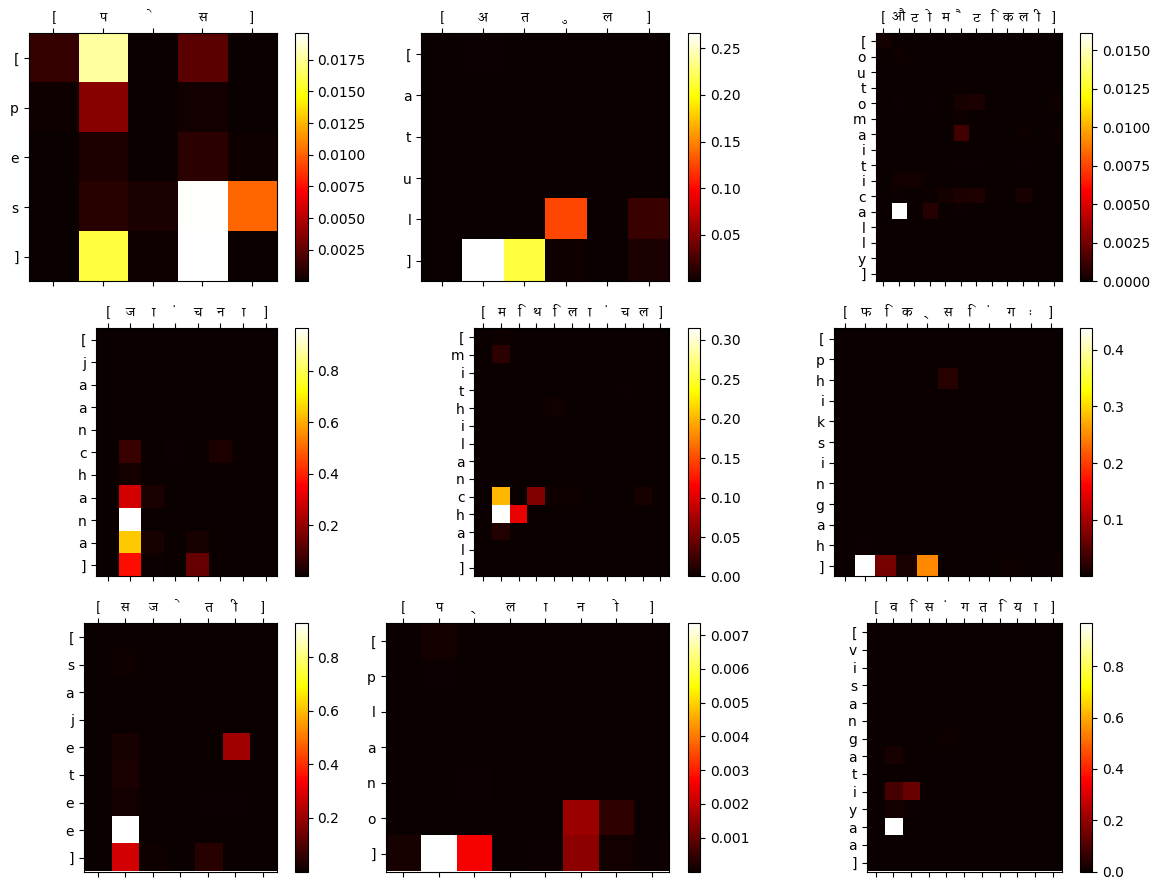

In [116]:
from matplotlib.font_manager import FontProperties


fig = plt.figure(figsize=(12, 9))
subplots = []

for j in range(9):
    subplots.append(fig.add_subplot(3, 3, j+1))

def plot_attention_heatmap(attention_matrix, input_labels, output_labels, ax):
    heatmap = ax.matshow(attention_matrix, cmap='hot')
    #took reference from pytorch document provided in the question
    ax.set_yticks(np.arange(len(input_labels)))
    ax.set_yticklabels(input_labels,rotation=0)
    h_font=FontProperties(fname='/kaggle/input/hindifont/VesperLibre-Regular.ttf')

    
    ax.set_xticks(np.arange(len(output_labels)))
    ax.set_xticklabels(output_labels, fontproperties=h_font)

   
    cbar = plt.colorbar(heatmap)
    plt.tight_layout()


for j in range(9):
    inp_len = len(test_pairs[ind_range+j][0])
    out_len = len(test_pairs[ind_range+j][1])
    new = best_attention[j][:inp_len]
    temp = np.zeros((inp_len, out_len))
    for i in range(new.shape[0]):
        temp[i] = new[i][:out_len].to(device='cpu').numpy()

    plot_attention_heatmap(temp, test_pairs[ind_range+j][0], test_pairs[ind_range+j][1], subplots[j])


plt.savefig('attention_heatmaps.png',bbox_inches='tight')
plt.show()
run=wandb.init(project="assignment3",entity="cs22m025",reinit=True)
wandb.log({ "confusion_matrix": wandb.Image('/kaggle/working/attention_heatmaps.png') })
run.finish()